In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import pymc3 as pm
import pymc3_ext as pmx

import dynesty as dyn
from dynesty import plotting as dynplot

import corner

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Generate data

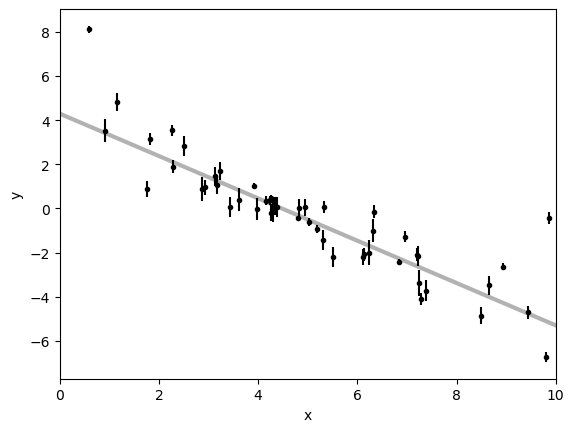

In [2]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x_obs = np.sort(10 * np.random.rand(N))
y_err = 0.1 + 0.5 * np.random.rand(N)
y_obs = m_true * x_obs + b_true
y_obs += np.abs(f_true * y_obs) * np.random.randn(N)
y_obs += y_err * np.random.randn(N)

x_plot = np.linspace(0, 10, N)
y_plot = m_true * x_plot + b_true

plt.errorbar(x_obs, y_obs, yerr=y_err, fmt="k.", capsize=0)
plt.plot(x_plot, y_plot, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

## Using `emcee` (Affine Invariant Ensemble Sampling)

This problem was adapted from the tutorial "[fitting a model to data](https://emcee.readthedocs.io/en/stable/tutorials/line/)" from the `emcee` documentation. The solution is available by following that tutorial.

## Using `PyMC3` (Hamiltonian Monte Carlo)

In [3]:
x_plot = np.linspace(0,10,N)

with pm.Model() as model:
    m = pm.Uniform('m', lower=-5, upper=1)
    b = pm.Uniform('b', lower=0, upper=10)
    log_f = pm.Uniform('log_f', lower=-10, upper=1)
    
    y_mod = m*x_obs + b
    s_mod = pm.math.sqrt(y_err**2 + pm.math.exp(2*log_f)*y_mod**2)
    
    y_plot = pm.Deterministic('y_plot', m*x_plot + b)
    
    lnlike = pm.Normal('lnlike', mu=y_mod, sd=s_mod, observed=y_obs)
    
with model:    
    trace = pmx.sample(tune=8000, draws=1000, chains=2, target_accept=0.9, return_inferencedata=True)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_f, b, m]


/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/lsst-discovery/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 8_000 tune and 1_000 draw iterations (16_000 + 2_000 draws total) took 4 seconds.


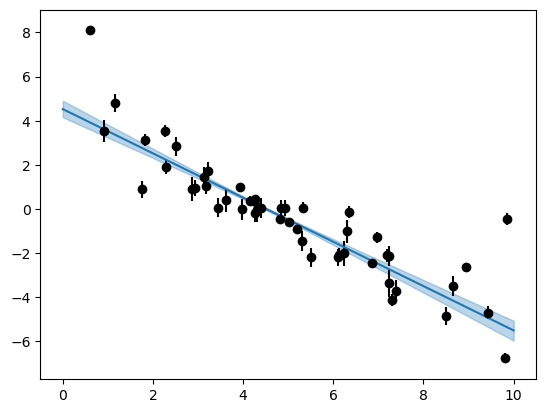

In [4]:
y_plot = np.percentile(trace.posterior.y_plot, [16,50,84], axis=[0,1])

plt.figure()
plt.errorbar(x_obs, y_obs, yerr=y_err, fmt='ko')
plt.plot(x_plot, y_plot[1], color='C0')
plt.fill_between(x_plot, y_plot[0], y_plot[2], color='C0', alpha=0.3)
plt.show()

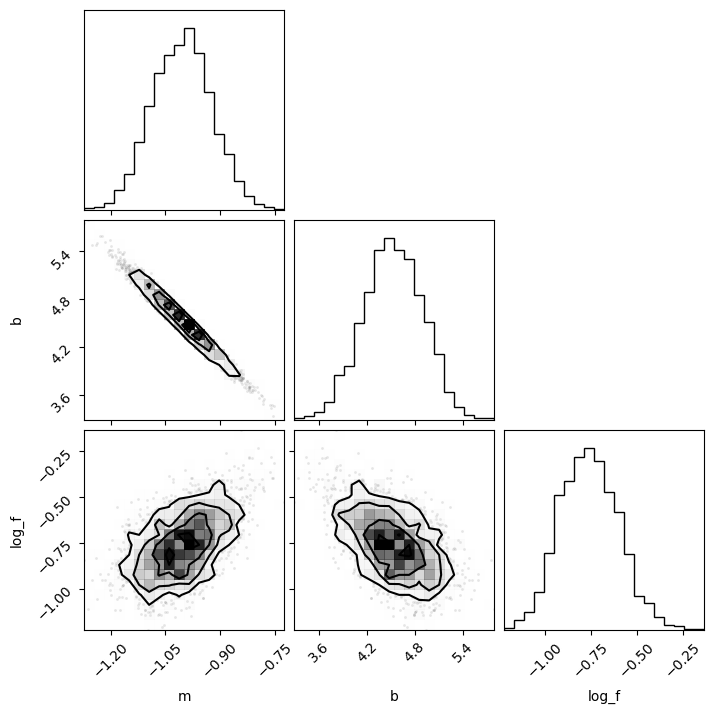

In [5]:
_ = corner.corner(trace, var_names=['m', 'b', 'log_f'])

## Using `dynesty` (Nested Sampling)

In [6]:
def uniform_ppf(u, a, b):
    """
    Transform the unit interval U~(0,1) to the interval U~(a,b)
    """
    return u*(b-a) + a


def prior_transform(u, ndim=3):
    theta = np.zeros(ndim, dtype='float')
    
    theta[0] = uniform_ppf(u[0], -5, 1)   # m ~ U(-5,1)
    theta[1] = uniform_ppf(u[1], 0, 10)   # b ~ U(0,10)
    theta[2] = uniform_ppf(u[2], -10, 1)  # log_f ~ U(-10,1)

    return theta


def lnlike(theta, x_obs, y_obs, y_err):
    m, b, log_f = theta
    
    y_mod = m * x_obs + b
    s_mod = np.sqrt(y_err**2 + y_mod**2 * np.exp(2*log_f))
    
    return -0.5 * np.sum((y_obs - y_mod) ** 2 / s_mod**2 + 2*np.log(s_mod))

In [7]:
# initialize the nested sampler
ndim = 3

sampler = dyn.NestedSampler(lnlike, prior_transform, ndim, logl_args=[x_obs, y_obs, y_err])
sampler.run_nested()

results = sampler.results

iter: 3000 | bound: 6 | nc: 1 | ncall: 21692 | eff(%): 13.830 | loglstar:   -inf < -43.166 <    inf | logz: -51.917 +/-  0.125 | dlogz: 33.580 >  0.509                                               IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

iter: 6008 | +500 | bound: 15 | nc: 1 | ncall: 29203 | eff(%): 22.674 | loglstar:   -inf < -12.213 <    inf | logz: -23.442 +/-  0.147 | dlogz:  0.001 >  0.509                                       

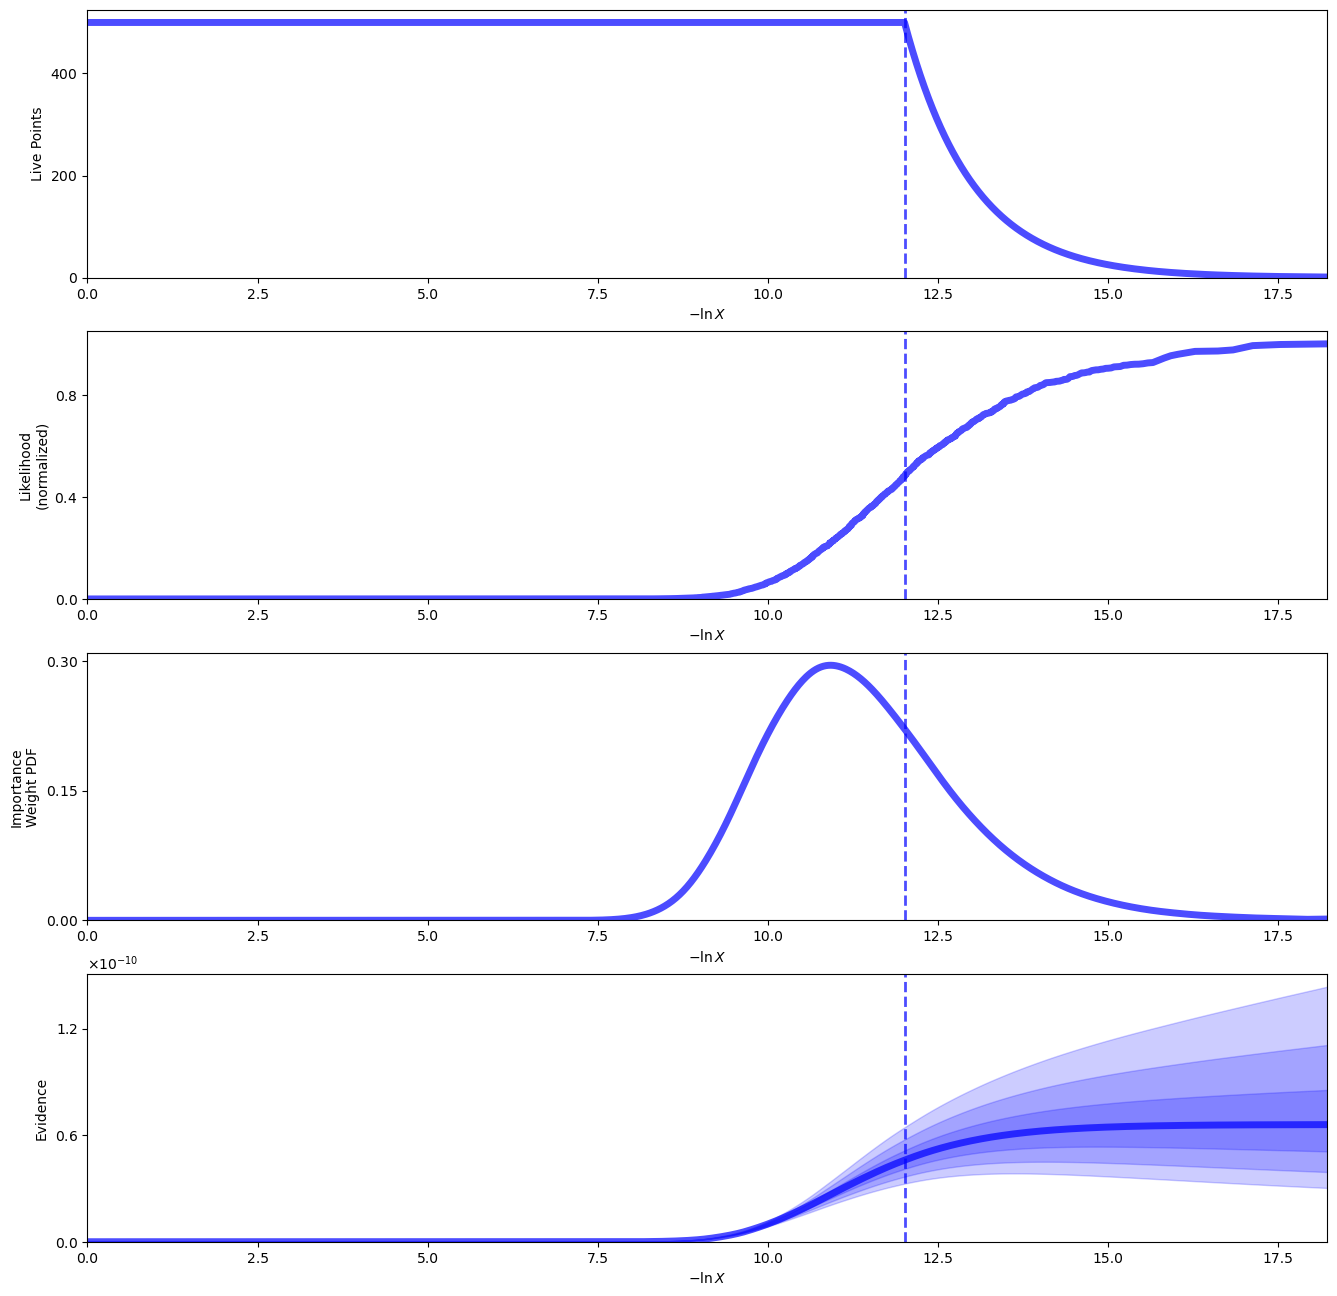

In [13]:
_ = dynplot.runplot(results)

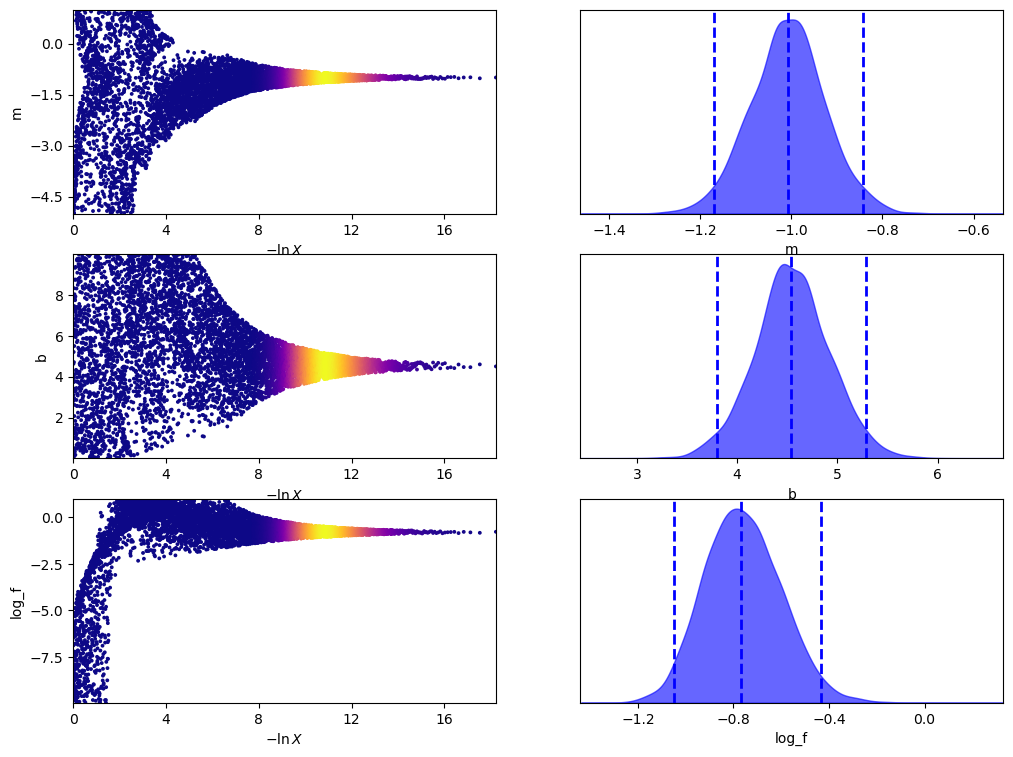

In [14]:
_ = dynplot.traceplot(results, labels=['m', 'b', 'log_f'])

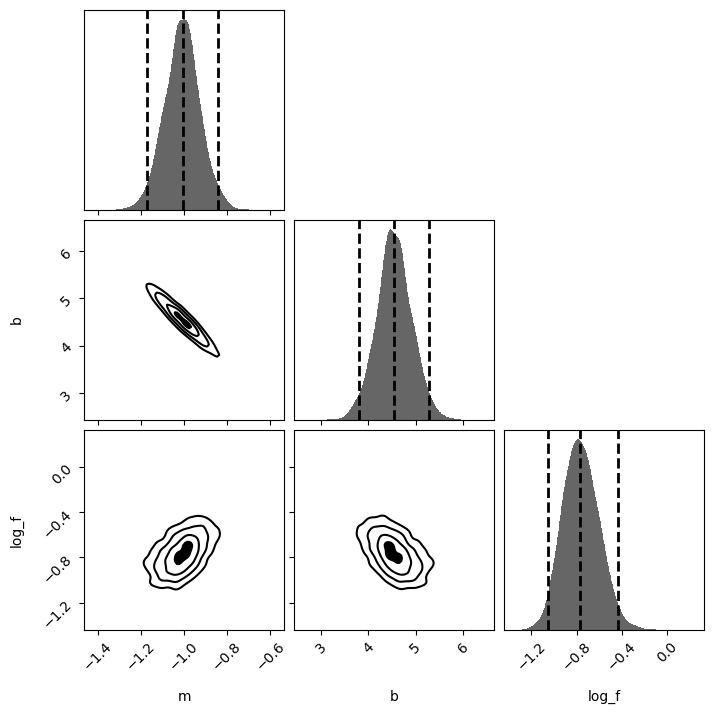

In [16]:
_ = dynplot.cornerplot(results, labels=['m', 'b', 'log_f'])